In [ ]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# This contains basic KNN network for calculation of fitness 
# 1. KNN class and modelling gives accuracy as output
class Solve:
  def __init__(self,dataset,dim,N):
    self.df=dataset
    self.dim=None
    self.N=None
  def modelling(self):
    self.N,self.dim=self.df.shape
    self.X=self.df.drop(['class'],axis=1)
    self.y=self.df['class']
    X_train,X_test,y_train,y_test=train_test_split(self.X,self.y,random_state=0,test_size=0.2)
    knn=KNeighborsClassifier(n_neighbors=2)
    knn.fit(X_train,y_train)
    pred=knn.predict(X_test)
    self.scores=cross_val_score(knn,self.X,self.y,cv=48,scoring='accuracy')
    return self.scores.mean()
# Fitness function: drop if list contains 0 and if add to new dataframe for evaluation if contains 1


In [ ]:
# Global variables
alpha=0.25
beta=0.5
gam=0.8
def open_left(x):  # Membership function for worst than average......Trapezoidal Membership Function
  if x>beta:
    return 0
  elif x<alpha:
    return 1
  else:
    return round((beta-x)/(beta-alpha),2)
def open_right(x):  # Membership function for more than average....Trapezoidal Membership Function
  if x<beta:
    return 0
  elif x>gam:
    return 1
  else:
    return round((x-beta)/(gam-beta),2)
def middle(x):
  if x<alpha or x>gam:
    return 0
  else:
    return round(max(min((x-alpha)/(beta-alpha),(beta-x)/(gam-beta)),0),2)

In [ ]:
def find_membership(dimentions):
  likelyhood=[]
  for i in dimentions:
    likelyhood.append(list((open_left(i),middle(i),open_right(i))))
  return likelyhood

In [ ]:
def fitness(feat):
  ionosphere=pd.read_csv("/content/ionosphere.csv")
  new_df=pd.DataFrame()
  likelihood=find_membership(feat)
  healthy_index=[]
  for i in range(len(likelihood)):
    if likelihood[i][2]>0.85:
      healthy_index.append(i)
  if len(healthy_index)==0:
    return 0
  for i in range(len(healthy_index)):
      new_df[ionosphere.columns[healthy_index[i]]]=ionosphere[ionosphere.columns[healthy_index[i]]]
  new_df['class']=ionosphere['class']
  solve=Solve(new_df,None,None)
  fit1=solve.modelling()
  return fit1
def generate_subset(feat):
  ionosphere=pd.read_csv("/content/ionosphere.csv")
  new_df=pd.DataFrame()
  likelihood=find_membership(feat)
  healthy_index=[]
  for i in range(len(likelihood)):
    if likelihood[i][2]>0.85:
      healthy_index.append(i)
  if len(healthy_index)==0:
    return 0
  for i in range(len(healthy_index)):
      new_df[ionosphere.columns[healthy_index[i]]]=ionosphere[ionosphere.columns[healthy_index[i]]]
  new_df['class']=ionosphere['class']
  return new_df

In [ ]:
# This contains function to generate position of wolf and the sigmoidal function
def pos(seed,dim):
  rnd=random.Random(seed)
  position=[0.0 for i in range(dim)]
  for i in range(dim):
    position[i]=rnd.uniform(0,1)
  return position
def transformv2(pos):
  for i in range(len(pos)):
    trans=abs(pos[i]/(1+pos[i]**2)**0.5)
    if trans>random.uniform(0,1):
      pos[i]=0
    else:
      pos[i]=1
  return pos
def transformv1(pos):
  for i in range(len(pos)):
    trans=abs(np.tanh(pos[i])/np.tanh(4))
    if trans>random.uniform(0,1):
      pos[i]=0
    else:
      pos[i]=1
  return pos
def transform(pos):
  for i in range(len(pos)):
    trans=(1/(1+np.exp(-10*(pos[i]-0.5))))
    if trans>random.uniform(0,1):
      pos[i]=0
    else:
      pos[i]=1
  return pos
def transform(pos):
  for i in range(len(pos)):
    trans=abs(math.erf(pos[i]))
    if trans>random.uniform(0,1):
      pos[i]=0
    else:
      pos[i]=1
  return pos
def SortByFitness(x,y):
  ind_sort=np.argsort(y)
  ind_sort=ind_sort.tolist()[::-1]
  a=[]
  b=[]
  for i in ind_sort:
    a.append(x[i])
    b.append(y[i])
  return a,b

In [ ]:
def GWO(n_wolf,dim,max_iter):
  wolf_position=[[random.uniform(0,1) for j in range(dim)] for i in range(n_wolf)]
  wolf_fitness=[fitness(i) for i in wolf_position]
  wolf_position,wolf_fitness=SortByFitness(wolf_position,wolf_fitness)
  Xa,Xb,Xd=wolf_position[0],wolf_position[1],wolf_position[2]
  iter=1
  while iter<=max_iter:
    a=2*(1-(iter/max_iter))
    # Updating position for each wolves
    for i in range(n_wolf):
      A1,A2,A3=a*(2*random.uniform(0,1)-1),a*(2*random.uniform(0,1)-1),a*(2*random.uniform(0,1)-1)
      C1,C2,C3=a*random.uniform(0,1),a*random.uniform(0,1),a*random.uniform(0,1)
      Da=abs(np.multiply(C1,Xa)-wolf_position[i])
      Db=abs(np.multiply(C2,Xb)-wolf_position[i])
      Dd=abs(np.multiply(C3,Xd)-wolf_position[i])

      X1=np.subtract(Xa,np.multiply(A1,Da))
      X2=np.subtract(Xb,np.multiply(A2,Db))
      X3=np.subtract(Xd,np.multiply(A3,Dd))

      X=np.add(X1,X2)
      X=np.add(X,X3)
      X=np.divide(X,3)
      X=X.tolist()
      # Greedy updating if condition holds
      fit=fitness(X)
      if fit>wolf_fitness[i]:
        wolf_position[i]=X
        wolf_fitness[i]=fit
    ## Updating Xa,Xb,Xc
    wolf_position,wolf_fitness=SortByFitness(wolf_position,wolf_fitness)
    Xa,Xb,Xd=wolf_position[0],wolf_position[1],wolf_position[2]
    
    iter+=1
  return Xa

In [ ]:
accuracy=[]
for i in range(2):
  Xa=GWO(10,34,10)
  accuracy.append([Xa,fitness(Xa)])
  print(f"{i} th iteration done !!")

0 th iteration done !!
1 th iteration done !!


In [ ]:
imax=0
ac_max=0
accuracy_data=[]
for i,ac in enumerate(accuracy):
  accuracy_data.append(ac[1])
  if abs(ac_max-max(ac_max,ac[1])) !=0:
    ac_max=max(ac[1],ac_max)
    imax=i
print(f"Maximum Model accuracy is : {100*accuracy[imax][1]}")

Maximum Model accuracy is : 91.07142857142856


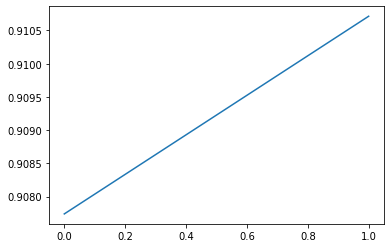

In [ ]:
plt.plot(range(2),accuracy_data)

In [ ]:
cleaned_data=generate_subset(accuracy[imax][0])
cleaned_data.to_csv("Ionosphere_reduced_data.csv")

In [ ]:
d=pd.read_csv("/content/Ionosphere_reduced_data.csv")

In [ ]:
d

,Unnamed: 0,a01,a03,a04,a05,a06,a07,a08,a09,a11,...,a24,a25,a26,a27,a28,a29,a30,a31,a32,class
0,0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.85243,...,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,g
1,1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,0.50874,...,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,b
2,2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.73082,...,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,g
3,3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,b
4,4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,0.52798,...,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,346,1,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,0.89391,...,0.06618,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,g
347,347,1,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.96510,...,0.10087,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,g
348,348,1,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.94124,...,0.06148,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,g
349,349,1,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.89724,...,-0.02320,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,g
